# **`--- IMPORTS ---`**

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))
display(HTML("<style>div.output_scroll {height: 28em;}</style>"))
display(HTML("<style>.rendered_html {font-size: 16px;}</style>"))

C:\Users\es77720738n\AppData\Local\Temp\ipykernel_11488\1854931357.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
from catboost import CatBoostClassifier
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
import seaborn as sns
import joblib
from datetime import datetime
from sklearn.metrics import roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, classification_report, precision_score, recall_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
import os

if os.path.basename(os.path.normpath(os.getcwd())) != 'streamlit-example':
    os.chdir('../')
    print('Changed path to "root" folder')    

Changed path to "root" folder


# **`--- READ DATA ---`**

In [4]:
accounts_train = pd.read_csv('data/accounts_train.csv')
quotes_train = pd.read_csv('data/quotes_train.csv')

accounts_test = pd.read_csv('data/accounts_test.csv')
quotes_test = pd.read_csv('data/quotes_test.csv')

In [5]:
print(accounts_train.shape)
display(accounts_train.head())

print(quotes_train.shape)
display(quotes_train.head())

(5709, 9)


,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0
1,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0
2,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0
3,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0
4,2b2ceb23-20eb3-9a3c-87034-2eccac7276,AZ,Retail Trade,Tobacco Stores,2014.0,200000.0,0.0,Limited Liability Company,0.0


(11724, 5)


,account_uuid,product,premium,carrier_id,convert
0,f09e1383-2467-4741-9bd3-39cfd7a2b399,Business_Owners_Policy_BOP,4316.0,29,0
1,8e686305-a622-4f24-ba0a-478fcbbee32c,Commercial_Auto,2085.0,9,0
2,f13a4b1b-f1fe3-3e49-f60c2-824c38e79a,Business_Owners_Policy_BOP,607.0,60,0
3,8f58d58a-762b-40b2-8a9e-6adaa4c31ea5,Workers_Compensation,779.0,22,1
4,76eaf5b0-ed02d-3d49-15cf5-3745425c15,Workers_Compensation,10086.0,29,1


In [6]:
print(accounts_test.shape)
display(accounts_test.head())

print(quotes_test.shape)
display(quotes_test.head())

(2448, 9)


,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees
0,7c7089b9-30cc6-c5fc-9f5c8-1e4ce6a8c3,FL,"Technology, Media and Telecommunications",Software Publishers,2014.0,1200000.0,1000000.0,Corporation,11.0
1,bf68dd36-7dc94-0f5d-ebad4-19c0cdcdc7,TX,Administrative Services and Building Maintenance,Carpet and Upholstery Cleaning Services,2017.0,75000.0,1.0,Individual,0.0
2,fc97744d-9e9a-47a9-b923-1e2c3016c896,CA,Healthcare,Diagnostic Imaging Centers,2018.0,500000.0,70000.0,Limited Liability Company,3.0
3,0484a0e0-3c35e-0d2a-14c01-0220295202,CO,Consultants,Administrative Management and General Manageme...,2017.0,70000.0,0.0,Individual,0.0
4,673e8fb9-23833-3654-c6082-67470cfedb,AL,NaN,NaN,2017.0,156000.0,0.0,Other,0.0


(5005, 4)


,account_uuid,product,premium,carrier_id
0,cadb76f5-2f0ad-a78b-6c138-001288b999,Business_Owners_Policy_BOP,518.0,60
1,cadb76f5-2f0ad-a78b-6c138-001288b999,Business_Owners_Policy_BOP,542.0,60
2,d8aed557-aa49-4e6c-8f1d-860fa56e633f,General_Liability,500.0,39
3,08ec2c90-b3037-3f8e-429af-f834f19937,Business_Owners_Policy_BOP,500.0,31
4,14a4b644-740b-454e-8872-3460fda39092,CW_Professional_Liability,400.0,31


# **`--- PROCESS DATA ---`**

## **Duplicates**

In [7]:
# -- ¿DUPLICATES? --

print(accounts_train.duplicated().sum())
print(quotes_train.duplicated().sum())

0
580


In [8]:
# -- DELETE DUPLICATED ROWS --

quotes_train.drop_duplicates(inplace=True)

## **Merge tables**

In [9]:
# -- CREATE FULL TABLE MERGING BOTH FILES --

train = accounts_train.merge(quotes_train, how='left', on='account_uuid')
train.head()

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1177.0,39,0
1,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1908.0,31,1
2,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0,Business_Owners_Policy_BOP,970.0,30,1
3,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0,General_Liability,816.0,31,1
4,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0,CW_Inland_Marine,500.0,39,1


In [10]:
# -- CALCULATE THE CONTRIBUTION TO THE ACCOUNT VALUE OF EACH PRODUCT --

train['account_value_by_product'] = train['premium']*train['convert']
train.head()

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,account_value_by_product
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1177.0,39,0,0.0
1,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1908.0,31,1,1908.0
2,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0,Business_Owners_Policy_BOP,970.0,30,1,970.0
3,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0,General_Liability,816.0,31,1,816.0
4,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0,CW_Inland_Marine,500.0,39,1,500.0


## **NaN values**

In [11]:
train.isna().sum()

account_uuid                  0
state                        39
industry                    240
subindustry                 240
year_established             70
annual_revenue               49
total_payroll                91
business_structure            2
num_employees                84
product                       0
premium                       0
carrier_id                    0
convert                       0
account_value_by_product      0
dtype: int64

In [12]:
np.round(train.isna().sum()/train.shape[0], 3)

account_uuid                0.000
state                       0.003
industry                    0.022
subindustry                 0.022
year_established            0.006
annual_revenue              0.004
total_payroll               0.008
business_structure          0.000
num_employees               0.008
product                     0.000
premium                     0.000
carrier_id                  0.000
convert                     0.000
account_value_by_product    0.000
dtype: float64

In [13]:
# -- SINCE THE PROPORTION OF NaN VALUES IS LOW, WE DELETE THESE VALUES --

train.dropna(inplace=True)

## **Cast columns**

In [14]:
train.dtypes

account_uuid                 object
state                        object
industry                     object
subindustry                  object
year_established            float64
annual_revenue              float64
total_payroll               float64
business_structure           object
num_employees               float64
product                      object
premium                     float64
carrier_id                    int64
convert                       int64
account_value_by_product    float64
dtype: object

In [15]:
# -- CAST COLUMNS TO PROPER TYPE --

train['carrier_id'] = 'carrier_id_' + train['carrier_id'].astype(str)
train['year_established'] = train['year_established'].astype(int)
# train['year_established'] = train['year_established'].astype(object)
train['num_employees'] = train['num_employees'].astype(int)

## **Clean data**

### `year_established`

In [16]:
train['year_established'].value_counts().sort_index()

1001       1
1906       2
1916       9
1920       5
1928       2
        ... 
2015     673
2016     820
2017    3959
2018    2077
2107       1
Name: year_established, Length: 65, dtype: int64

In [17]:
# -- DELETE YEARS WHICH DOES NOT MAKE ANY SENSE --

train = train[(train['year_established'] > 1900) & (train['year_established'] < 2023)]

### `num_employees`

In [18]:
train.num_employees.value_counts()

0        6977
1        1377
2         949
3         374
4         339
5         194
6         138
7          86
10         82
8          58
9          56
11         34
12         25
15         19
13         10
20         10
24         10
17          9
14          8
80          8
25          8
21          7
26          6
16          6
48          5
45          5
19          4
18          4
40          3
23          3
50          2
36000       2
52          2
55          1
Name: num_employees, dtype: int64

In [19]:
train[train.num_employees > 3000]

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,account_value_by_product
5569,7dff1bf4-bdb02-d673-b83ce-362726d1a6,LA,Contractors,Painting and Wall Covering Contractors,2017,60000.0,0.0,Limited Liability Company,36000,Workers_Compensation,1633.0,carrier_id_22,1,1633.0
5570,7dff1bf4-bdb02-d673-b83ce-362726d1a6,LA,Contractors,Painting and Wall Covering Contractors,2017,60000.0,0.0,Limited Liability Company,36000,General_Liability,752.0,carrier_id_39,1,752.0


In [20]:
train[train.business_structure == "Limited Liability Company"]['num_employees'].describe()

count     4943.000000
mean        15.984625
std        724.051035
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max      36000.000000
Name: num_employees, dtype: float64

In [21]:
# -- BASED ON THE num_employees OF LLC's, WE MAY SUPPOSE THAT 36000 EMPLOYEES IS INDEED AN ERROR OR OUTILIER -> DELETE THESE VALUES --

train = train[train.num_employees < 200]

### `subindustry`

In [22]:
# -- VARIABLE WITH HIGH CARDINALITY -- 

train.subindustry.nunique()

482

In [23]:
df_subindustry = train.groupby('subindustry')['account_uuid'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'account_uuid': 'n_occurrences'})
df_subindustry

,subindustry,n_occurrences
0,Janitorial Services,692
1,Residential Remodelers,471
2,Landscaping Services,395
3,Beauty Salons,288
4,Painting and Wall Covering Contractors,268
...,...,...
477,Curtain and Linen Mills,1
478,Farm and Garden Machinery and Equipment Mercha...,1
479,Ophthalmic Goods Merchant Wholesalers,1
480,Farm Supplies Merchant Wholesalers,1


In [24]:
df_subindustry['subindustry_grouped'] = df_subindustry.apply(lambda row: row['subindustry'] if row['n_occurrences'] > 20 else 'Other', axis=1)
df_subindustry

,subindustry,n_occurrences,subindustry_grouped
0,Janitorial Services,692,Janitorial Services
1,Residential Remodelers,471,Residential Remodelers
2,Landscaping Services,395,Landscaping Services
3,Beauty Salons,288,Beauty Salons
4,Painting and Wall Covering Contractors,268,Painting and Wall Covering Contractors
...,...,...,...
477,Curtain and Linen Mills,1,Other
478,Farm and Garden Machinery and Equipment Mercha...,1,Other
479,Ophthalmic Goods Merchant Wholesalers,1,Other
480,Farm Supplies Merchant Wholesalers,1,Other


In [25]:
df_subindustry['subindustry_grouped'].value_counts()

Other                                                          378
Employment Placement Agencies                                    1
Commercial Photography                                           1
Clothing Accessories Stores                                      1
Automotive Body, Paint, and Interior Repair and Maintenance      1
                                                              ... 
General Freight Trucking, Local                                  1
Appliance Repair and Maintenance                                 1
Other Services to Buildings and Dwellings                        1
Religious Organizations                                          1
All Other General Merchandise Stores                             1
Name: subindustry_grouped, Length: 105, dtype: int64

In [26]:
train = train.merge(df_subindustry.drop(columns='n_occurrences'), how='left', on='subindustry')
train.head()

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,account_value_by_product,subindustry_grouped
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012,120000.0,50000.0,Limited Liability Company,4,General_Liability,1177.0,carrier_id_39,0,0.0,Landscaping Services
1,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012,120000.0,50000.0,Limited Liability Company,4,General_Liability,1908.0,carrier_id_31,1,1908.0,Landscaping Services
2,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012,60000.0,40000.0,Limited Liability Company,1,Business_Owners_Policy_BOP,970.0,carrier_id_30,1,970.0,Electrical Contractors and Other Wiring Instal...
3,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015,75000.0,55000.0,Limited Liability Company,0,CW_Inland_Marine,500.0,carrier_id_39,1,500.0,Architectural Services
4,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015,75000.0,55000.0,Limited Liability Company,0,CW_Professional_Liability,1540.0,carrier_id_31,1,1540.0,Architectural Services


In [27]:
# -- WE MIGHT USE THIS GROUPED VARIABLE INSTEAD OF THE ORIGINAL ONE. CARDINALITY GOES FROM 482 TO 105 --

train['subindustry_grouped'].value_counts()

Other                                                                          2089
Janitorial Services                                                             692
Residential Remodelers                                                          471
Landscaping Services                                                            395
Beauty Salons                                                                   288
                                                                               ... 
Promoters of Performing Arts, Sports, and Similar Events without Facilities      22
Locksmiths                                                                       21
Architectural Services                                                           21
Gasoline Stations with Convenience Stores                                        21
Household Appliances, and Consumer Electronics Merchant Wholesalers              21
Name: subindustry_grouped, Length: 105, dtype: int64

## **Account value**

In [28]:
# -- CALCULATE THE ACCOUNT VALUE FOR EACH ACCOUNT_UUID --

train_account_values = train.groupby('account_uuid')['account_value_by_product'].sum().to_frame().rename(columns={'account_value_by_product': 'account_value'}).sort_values(by='account_value', ascending=False)
train_account_values.head()

,account_value
account_uuid,
1b3cadf5-01e2e-cb7b-22c3d-4879388a68,62111.0
87047ec6-4ef1c-73fe-a7c25-53b93d54c2,52382.0
e1613a34-eca2-4589-940d-e49fe339a25c,46333.0
7435711d-b8cf-4bd0-b04d-49f6ae48aee2,45745.0
e31d5efa-e1fdb-e74d-bec81-7c1614bfc9,35579.0


In [29]:
# -- INCLUDE THE ACCOUNT VALUE IN TABLE --

train = train.drop(columns='account_value_by_product').merge(train_account_values, how='left', on='account_uuid')
train.head()

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,subindustry_grouped,account_value
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012,120000.0,50000.0,Limited Liability Company,4,General_Liability,1177.0,carrier_id_39,0,Landscaping Services,1908.0
1,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012,120000.0,50000.0,Limited Liability Company,4,General_Liability,1908.0,carrier_id_31,1,Landscaping Services,1908.0
2,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012,60000.0,40000.0,Limited Liability Company,1,Business_Owners_Policy_BOP,970.0,carrier_id_30,1,Electrical Contractors and Other Wiring Instal...,970.0
3,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015,75000.0,55000.0,Limited Liability Company,0,CW_Inland_Marine,500.0,carrier_id_39,1,Architectural Services,2040.0
4,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015,75000.0,55000.0,Limited Liability Company,0,CW_Professional_Liability,1540.0,carrier_id_31,1,Architectural Services,2040.0


## **Profiling**

In [30]:
# GENERATE AN HTML PROFILE REPORT FOR FURTHER ANALYSIS --

profile = ProfileReport(train.drop(columns=['account_uuid', 'subindustry_grouped']), title="Pandas Profiling Report")
profile.to_file("Pandas Profiling Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# **`--- EDA ---`**

## **Correlation**
    Evaluation of the correlation between numerical variables

In [31]:
df_corr = train.drop(columns='account_value').corr()
df_corr

,year_established,annual_revenue,total_payroll,num_employees,premium,convert
year_established,1.000000,-0.096803,-0.106969,-0.085686,-0.033672,0.001050
annual_revenue,-0.096803,1.000000,0.478792,0.554488,0.239521,-0.018910
total_payroll,-0.106969,0.478792,1.000000,0.704618,0.171464,-0.029364
num_employees,-0.085686,0.554488,0.704618,1.000000,0.269709,-0.016290
premium,-0.033672,0.239521,0.171464,0.269709,1.000000,-0.007059
convert,0.001050,-0.018910,-0.029364,-0.016290,-0.007059,1.000000


C:\Users\es77720738n\AppData\Local\Temp\ipykernel_11488\4144183168.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_corr, dtype=np.bool))


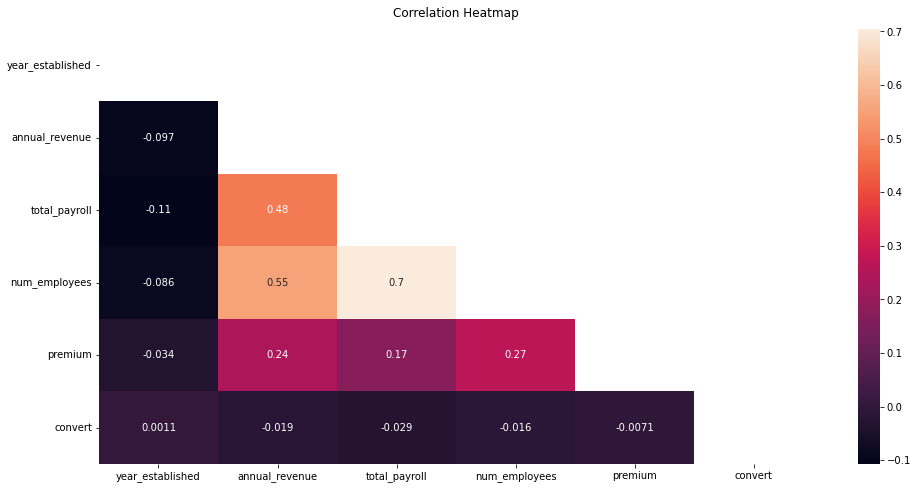

In [32]:
plt.figure(figsize=(16,8))

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
heatmap = sns.heatmap(df_corr, annot=True, mask=mask,)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

## **Describe**

In [33]:
train.groupby('convert').describe().T

convert                            0             1
year_established count  4.310000e+03  6.509000e+03
                 mean   2.013332e+03  2.013350e+03
                 std    8.830318e+00  8.235823e+00
                 min    1.906000e+03  1.906000e+03
                 25%    2.013000e+03  2.013000e+03
                 50%    2.017000e+03  2.017000e+03
                 75%    2.017000e+03  2.017000e+03
                 max    2.018000e+03  2.018000e+03
annual_revenue   count  4.310000e+03  6.509000e+03
                 mean   2.368405e+05  2.031550e+05
                 std    8.930683e+05  8.577560e+05
                 min    0.000000e+00  0.000000e+00
                 25%    3.500000e+04  3.000000e+04
                 50%    7.000000e+04  6.000000e+04
                 75%    1.500000e+05  1.500000e+05
                 max    2.000000e+07  2.000000e+07
total_payroll    count  4.310000e+03  6.509000e+03
                 mean   4.988545e+04  3.663803e+04
                 std    2.689983e+05  1.819753e+05
                 min    0.000000e+00  0.000000e+00
                 25%    0.000000e+00  0.000000e+00
                 50%    0.000000e+00  0.000000e+00
                 75%    3.000000e+04  3.000000e+04
                 max    6.000000e+06  6.000000e+06
num_employees    count  4.310000e+03  6.509000e+03
                 mean   1.374942e+00  1.245813e+00
                 std    4.183095e+00  3.666421e+00
                 min    0.000000e+00  0.000000e+00
                 25%    0.000000e+00  0.000000e+00
                 50%    0.000000e+00  0.000000e+00
                 75%    1.000000e+00  1.000000e+00
                 max    8.000000e+01  8.000000e+01
premium          count  4.310000e+03  6.509000e+03
                 mean   1.439233e+03  1.401669e+03
                 std    2.526970e+03  2.656102e+03
                 min    7.500000e+01  1.000000e+00
                 25%    5.000000e+02  5.000000e+02
                 50%    6.500000e+02  6.260000e+02
                 75%    1.337750e+03  1.217000e+03
                 max    4.098700e+04  6.211100e+04
account_value    count  4.310000e+03  6.509000e+03
                 mean   1.636574e+03  2.084522e+03
                 std    3.169172e+03  4.024521e+03
                 min    2.925000e+01  2.925000e+01
                 25%    5.000000e+02  5.000000e+02
                 50%    6.850000e+02  8.500000e+02
                 75%    1.392000e+03  1.812000e+03
                 max    5.238200e+04  6.211100e+04

## **Numerical columns**

In [34]:
# -- USERS WITH MORE TRANSACTIONS --

train['account_uuid'].value_counts(dropna=False).head()

387b20e2-28d6-4ada-8c29-9f81f50372e7    12
0b71ae5a-6c44e-9426-0f271-6f86be6d1c    11
c4748583-d523-4e8a-ab15-a5d3f20b10c6    11
40306000-a74f5-a9c7-bc993-59fcadfe16    11
251c0e25-85b79-ddf9-c559a-b2ac76e326    10
Name: account_uuid, dtype: int64

In [35]:
# -- CHECK THE account_value OF THIS USER --

train[train.account_uuid == train['account_uuid'].value_counts(dropna=False).index[0]]

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,subindustry_grouped,account_value
2722,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,General_Liability,250.0,carrier_id_21,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2723,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,General_Liability,350.0,carrier_id_60,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2724,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,564.0,carrier_id_30,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2725,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,854.0,carrier_id_39,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2726,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,589.0,carrier_id_60,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2727,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,733.0,carrier_id_60,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2728,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,750.0,carrier_id_60,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2729,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,810.0,carrier_id_30,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2730,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,1303.0,carrier_id_39,1,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0
2731,387b20e2-28d6-4ada-8c29-9f81f50372e7,MI,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2015,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,804.0,carrier_id_60,0,"Cosmetics, Beauty Supplies, and Perfume Stores",1303.0


In [36]:
num_features = train.select_dtypes(exclude='object').drop(columns=['convert', 'account_value']).columns.tolist()
num_features

['year_established',
 'annual_revenue',
 'total_payroll',
 'num_employees',
 'premium']

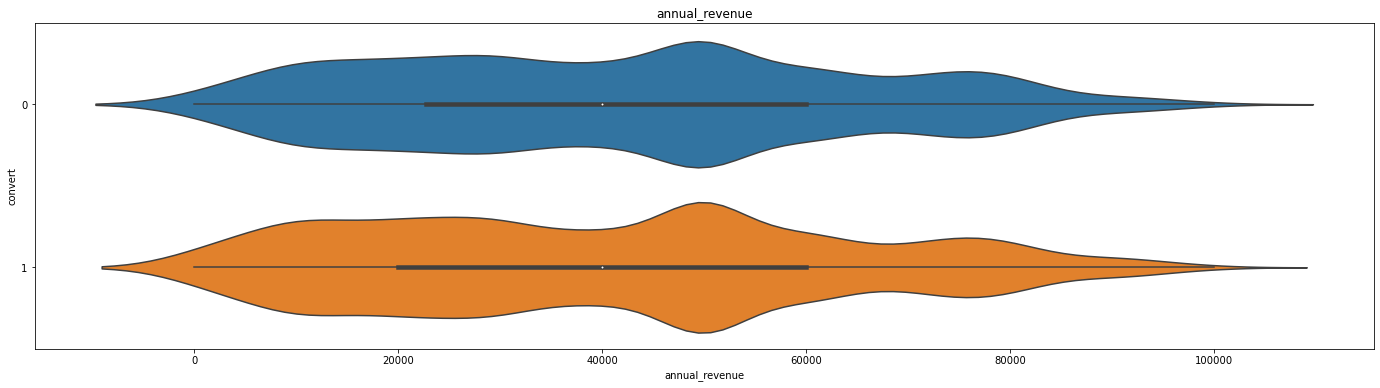

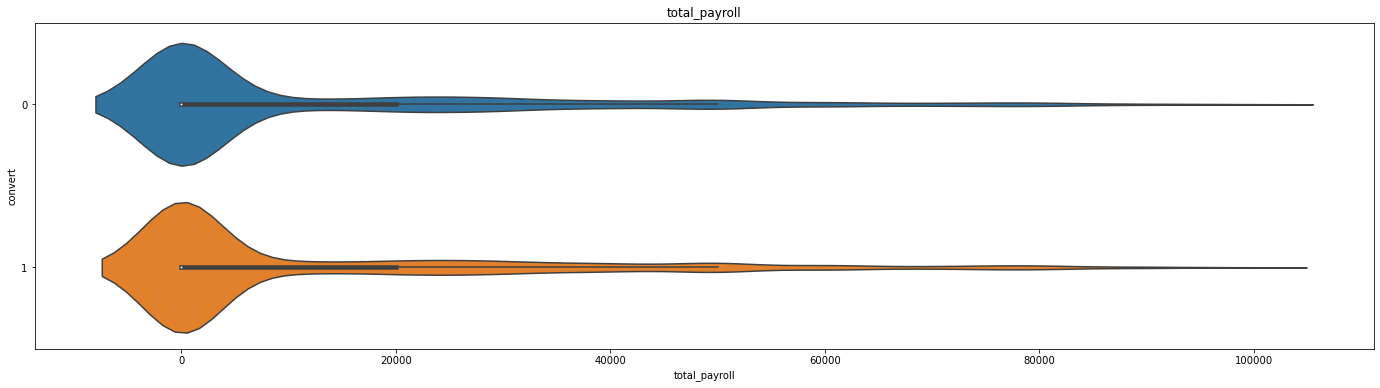

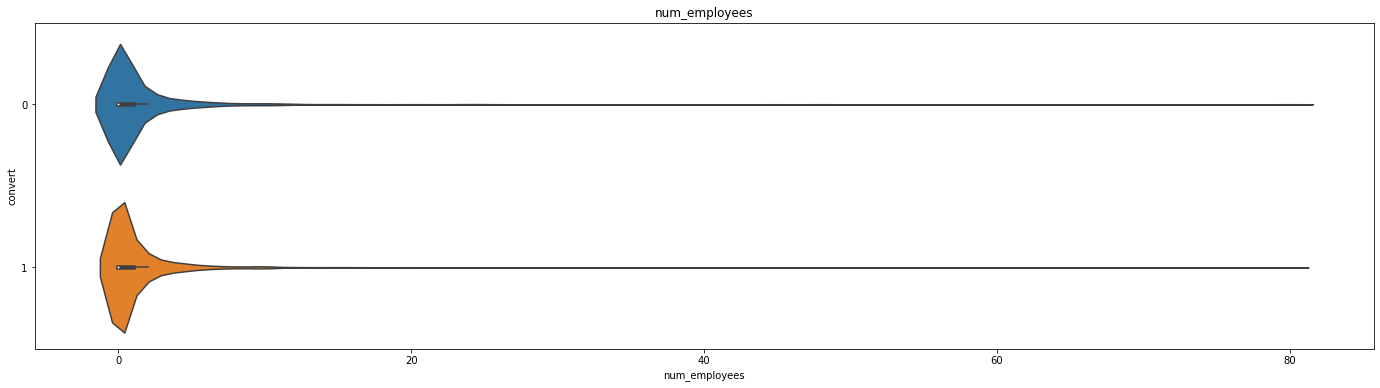

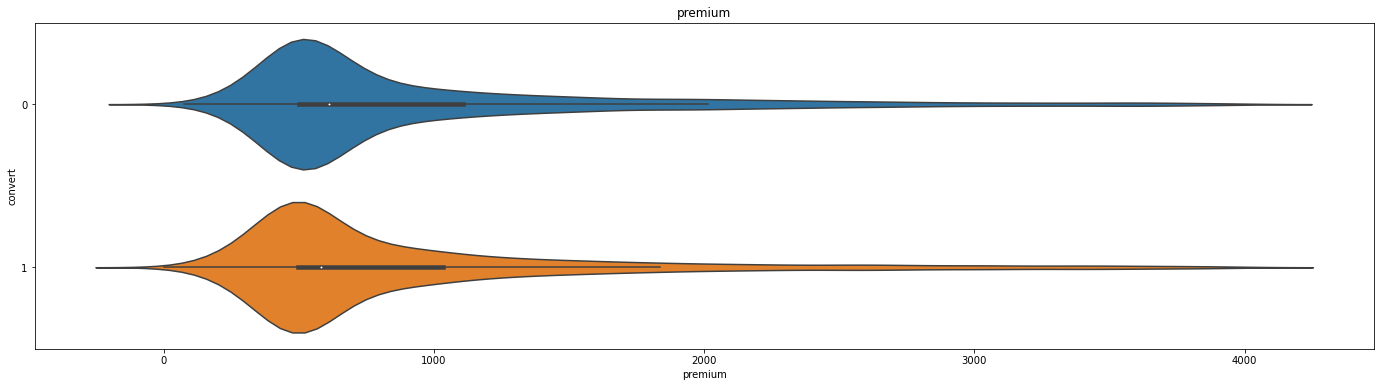

In [37]:
plt.figure(figsize=(24, 6))
x = 'annual_revenue'
sns.violinplot(data=train[train[x] < 1e5], y='convert', x=x, orient='h')
plt.title(x)
plt.show()

plt.figure(figsize=(24, 6))
x = 'total_payroll'
sns.violinplot(data=train[train[x] < 1e5], y='convert', x=x, orient='h')
plt.title(x)
plt.show()

plt.figure(figsize=(24, 6))
x = 'num_employees'
sns.violinplot(data=train[train[x] < 1e5], y='convert', x=x, orient='h')
plt.title(x)
plt.show()

plt.figure(figsize=(24, 6))
x = 'premium'
sns.violinplot(data=train[train[x] < 4000], y='convert', x=x, orient='h')
plt.title(x)
plt.show()

## **Categorical columns**

In [38]:
cat_features = train.select_dtypes(include='object').drop(columns=['account_uuid', 'subindustry']).columns.tolist()
cat_features

['state',
 'industry',
 'business_structure',
 'product',
 'carrier_id',
 'subindustry_grouped']

In [39]:
train[cat_features].head()

,state,industry,business_structure,product,carrier_id,subindustry_grouped
0,PA,Retail Trade,Limited Liability Company,General_Liability,carrier_id_39,Landscaping Services
1,PA,Retail Trade,Limited Liability Company,General_Liability,carrier_id_31,Landscaping Services
2,TX,Contractors,Limited Liability Company,Business_Owners_Policy_BOP,carrier_id_30,Electrical Contractors and Other Wiring Instal...
3,CA,"Professional, Scientific and Technical Services",Limited Liability Company,CW_Inland_Marine,carrier_id_39,Architectural Services
4,CA,"Professional, Scientific and Technical Services",Limited Liability Company,CW_Professional_Liability,carrier_id_31,Architectural Services


In [40]:
for col in cat_features:
    df_aux = train.groupby(col).agg({'convert': [np.mean, 'count']})
    df_aux.columns = df_aux.columns.get_level_values(1)
    df_aux.rename(columns={'mean': 'convert_mean', 
                          'count': 'convert_count'}, inplace=True)
    display(df_aux.sort_values(by='convert_mean', ascending=False))

,convert_mean,convert_count
state,,
HI,1.000000,2
IA,0.750000,36
NE,0.720000,25
OR,0.716814,113
KY,0.715447,123
NM,0.702128,47
ID,0.692308,52
MT,0.666667,27
VT,0.666667,15


,convert_mean,convert_count
industry,,
Home Based Business,1.000000,1
"Agriculture, Forestry, Fishing and Hunting",1.000000,8
Transportation and Warehousing,0.864198,243
Rentals and Leasing,0.777778,9
Finance and Insurance,0.777108,166
Construction,0.775148,169
Real Estate,0.769231,221
Manufacturing,0.750000,320
"Sports, Arts, Entertainment, and Recreation",0.739130,184


,convert_mean,convert_count
business_structure,,
Other,0.711538,104
Non-Profit,0.666667,150
Individual,0.611262,3694
Corporation,0.601390,1726
Limited Liability Company,0.592997,4941
Partnership,0.544304,158
Limited Partnership,0.500000,42
Not sure yet,0.500000,2
Trust,0.500000,2


,convert_mean,convert_count
product,,
Accident_Group,1.000000,1
CW_Pollution_Liability,1.000000,1
Miscellaneous_Contract_Bond,1.000000,1
CW_Product_Liability,1.000000,3
CW_Ocean_Marine,1.000000,1
CW_Special_Events,0.909091,55
CW_Hired_Non_Owned_Auto,0.900000,10
CW_Medical_Malpractice,0.888889,9
CW_Garage_Liability,0.866667,30


,convert_mean,convert_count
carrier_id,,
carrier_id_57,1.000000,1
carrier_id_43,1.000000,1
carrier_id_34,1.000000,1
carrier_id_32,1.000000,2
carrier_id_52,1.000000,1
carrier_id_62,1.000000,1
carrier_id_68,1.000000,3
carrier_id_7,1.000000,1
carrier_id_25,1.000000,1


,convert_mean,convert_count
subindustry_grouped,,
Drinking Places (Alcoholic Beverages),0.954545,22
"General Freight Trucking, Local",0.883117,77
Other Individual and Family Services,0.880000,25
"General Freight Trucking, Long-Distance, Truckload",0.869565,46
Child Day Care Services,0.848485,66
...,...,...
"Household Appliances, and Consumer Electronics Merchant Wholesalers",0.333333,21
"Women's, Children's, and Infants' Clothing and Accessories Merchant Wholesalers",0.333333,24
"Photography Studios, Portrait",0.323529,34


**We find lot of differences between the values of the target `convert` for the different categorical variables**

In [41]:
def plot_heatmap(df, feature1, feature2, values='sg_proc', aggfunc='mean', figsize=None, display_table=False):
    table = pd.crosstab(df[feature1],
                        df[feature2],
                        values=df[values],
                        aggfunc=aggfunc)
    table_aux = pd.crosstab(df[feature1],
                            df[feature2],
                            values=df[values],
                            aggfunc=['count', aggfunc])

    if display_table:
        display(table_aux)

    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(30, 15))

    if aggfunc == 'mean':
        sns.heatmap(table,
                    annot=table,
                    cmap='coolwarm',
                    vmin=0,
                    vmax=1,
                    annot_kws={"size": 18},
                    linewidths=2)
        plt.title('{} media de {} por {}'.format(values, feature1, feature2))
    else:
        sns.heatmap(table, annot=table, fmt='.1f', cmap='coolwarm',
                    annot_kws={"size": 18}, linewidths=2)

    plt.show()

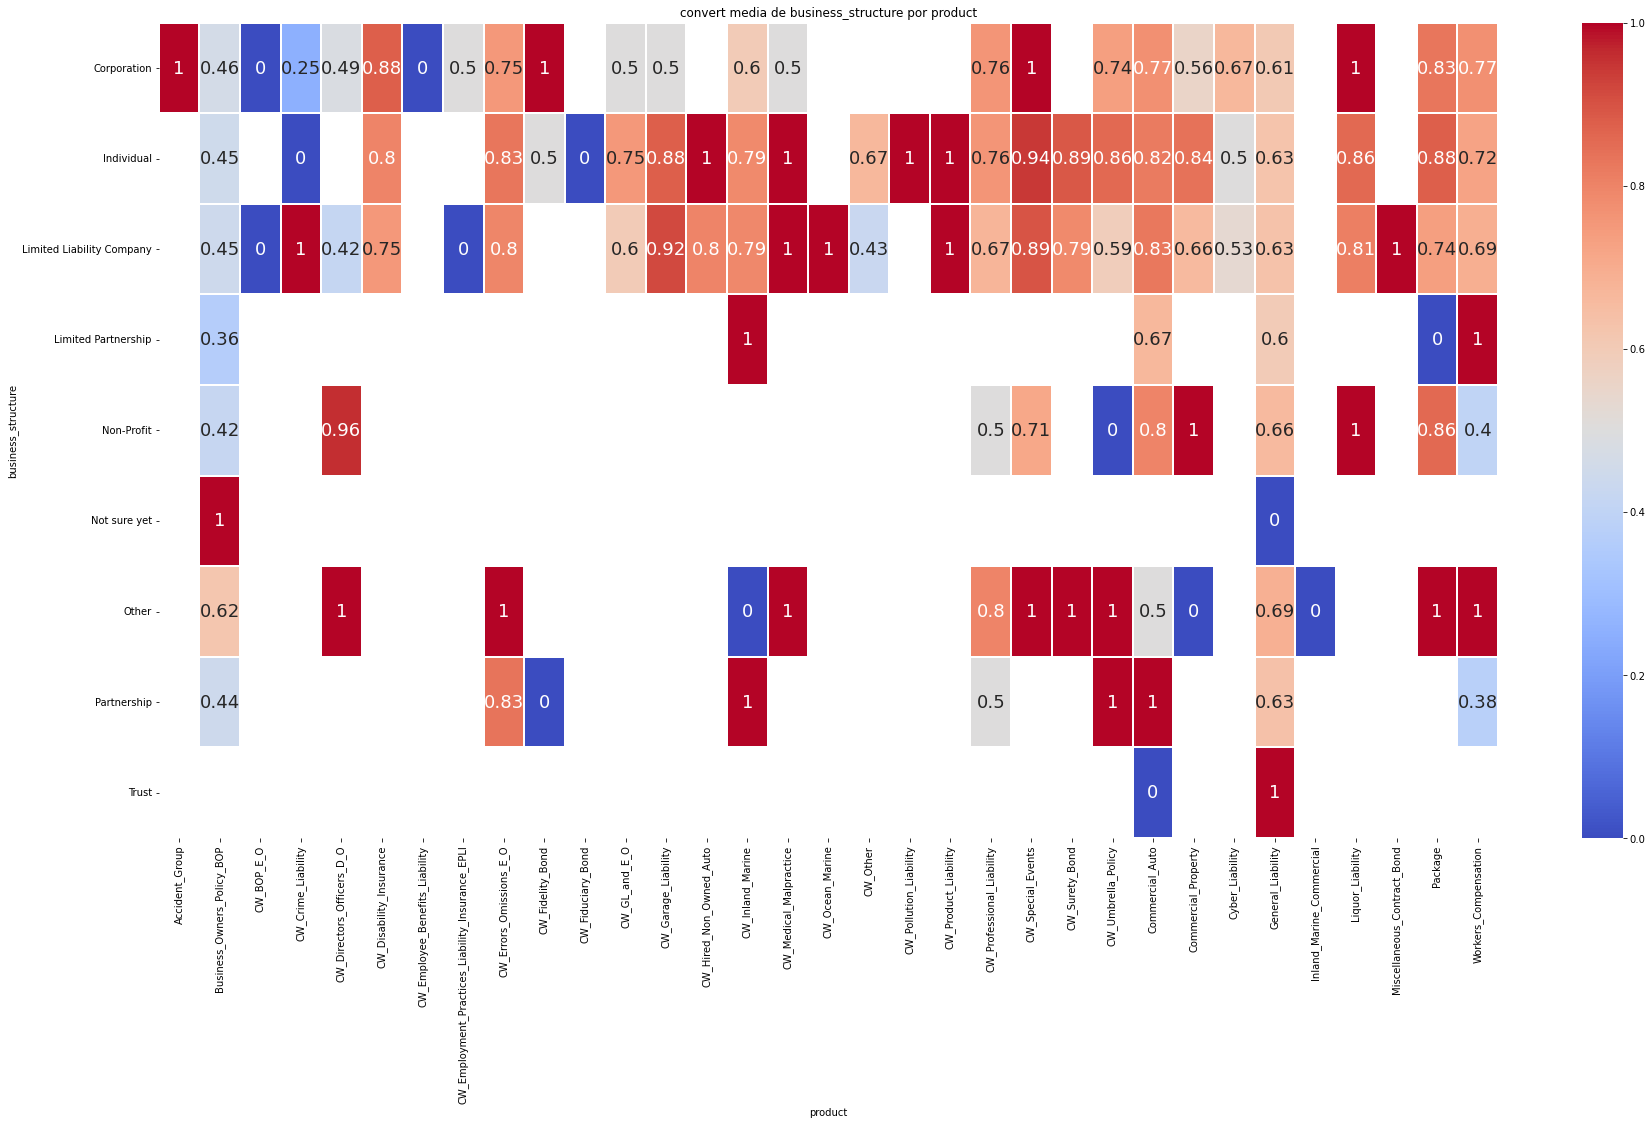

In [42]:
plot_heatmap(df=train, feature1='business_structure', feature2='product', values='convert')

# **`--- MODELING ---`**

In [43]:
df = train.copy()
df.sort_values(by='account_uuid', inplace=True)

In [44]:
df['convert'].value_counts(dropna=False)

1    6509
0    4310
Name: convert, dtype: int64

## **Feature selection**

In [45]:
target = 'convert'
# cols_to_drop = [target] + ['account_value', 'subindustry']
cols_to_drop = [target] + ['account_value', 'subindustry_grouped']

features = df.drop(columns=cols_to_drop).columns.tolist()
features

['account_uuid',
 'state',
 'industry',
 'subindustry',
 'year_established',
 'annual_revenue',
 'total_payroll',
 'business_structure',
 'num_employees',
 'product',
 'premium',
 'carrier_id']

In [46]:
X = df[features]
Y = df[target]

print(X.shape)

(10819, 12)


In [47]:
# -- CATEGORICAL FEATURES -- 

X.select_dtypes(include='object').head()

,account_uuid,state,industry,subindustry,business_structure,product,carrier_id
10623,000f56d0-da32c-68f2-e611e-5de77846f8,GA,Manufacturing,Malt Manufacturing,Limited Liability Company,Workers_Compensation,carrier_id_24
10620,000f56d0-da32c-68f2-e611e-5de77846f8,GA,Manufacturing,Malt Manufacturing,Limited Liability Company,General_Liability,carrier_id_60
10621,000f56d0-da32c-68f2-e611e-5de77846f8,GA,Manufacturing,Malt Manufacturing,Limited Liability Company,Workers_Compensation,carrier_id_9
10622,000f56d0-da32c-68f2-e611e-5de77846f8,GA,Manufacturing,Malt Manufacturing,Limited Liability Company,Business_Owners_Policy_BOP,carrier_id_4
8411,00118ffe-d450f-c2ca-4ba15-d1eec8e54a,VA,"Professional, Scientific and Technical Services","All Other Professional, Scientific, and Techni...",Limited Liability Company,Business_Owners_Policy_BOP,carrier_id_30


In [48]:
# -- WE SEE HIGH CARDINALITY FOR CATEGORICAL VARIABLES --

[X[col].nunique() for col in X.select_dtypes(include='object').columns]

[5476, 50, 21, 482, 9, 33, 59]

## **Train/Test Split**

In [49]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)  # shuffle=False in case we want to keep the order
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

X_train = X_train_orig.drop(columns='account_uuid')
X_test = X_test_orig.drop(columns='account_uuid')

In [50]:
cat_features = X_train.select_dtypes(include='object').columns.tolist()
cat_features

['state',
 'industry',
 'subindustry',
 'business_structure',
 'product',
 'carrier_id']

In [51]:
clf = CatBoostClassifier()

# -- PARAM GRID --

# params = {'iterations': [125, 175, 200, 300, 400, 500],
#           'learning_rate': [0.05, 0.15, 0.3, 0.5],
#           'depth': [4, 5, 6, 7]
#           }

# -- BEST PARAMS --

params = {'iterations': [500],
          'learning_rate': [0.05],
          'depth': [6]
          }

clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1,verbose=False)

In [52]:
clf_grid.fit(X_train, y_train, cat_features=cat_features)

0:	learn: 0.6837061	total: 204ms	remaining: 1m 41s
1:	learn: 0.6763681	total: 228ms	remaining: 56.9s
2:	learn: 0.6688355	total: 251ms	remaining: 41.5s
3:	learn: 0.6617070	total: 276ms	remaining: 34.3s
4:	learn: 0.6563654	total: 303ms	remaining: 29.9s
5:	learn: 0.6505456	total: 330ms	remaining: 27.1s
6:	learn: 0.6465545	total: 343ms	remaining: 24.1s
7:	learn: 0.6423910	total: 357ms	remaining: 21.9s
8:	learn: 0.6375881	total: 378ms	remaining: 20.6s
9:	learn: 0.6326416	total: 401ms	remaining: 19.6s
10:	learn: 0.6283215	total: 426ms	remaining: 18.9s
11:	learn: 0.6249433	total: 448ms	remaining: 18.2s
12:	learn: 0.6212031	total: 471ms	remaining: 17.7s
13:	learn: 0.6176972	total: 493ms	remaining: 17.1s
14:	learn: 0.6139638	total: 515ms	remaining: 16.7s
15:	learn: 0.6111490	total: 538ms	remaining: 16.3s
16:	learn: 0.6091159	total: 560ms	remaining: 15.9s
17:	learn: 0.6063762	total: 583ms	remaining: 15.6s
18:	learn: 0.6035809	total: 605ms	remaining: 15.3s
19:	learn: 0.6011032	total: 629ms	remain

164:	learn: 0.4973059	total: 4.01s	remaining: 8.15s
165:	learn: 0.4971838	total: 4.04s	remaining: 8.12s
166:	learn: 0.4967316	total: 4.06s	remaining: 8.1s
167:	learn: 0.4965485	total: 4.08s	remaining: 8.07s
168:	learn: 0.4957480	total: 4.11s	remaining: 8.04s
169:	learn: 0.4950353	total: 4.13s	remaining: 8.02s
170:	learn: 0.4949347	total: 4.16s	remaining: 8s
171:	learn: 0.4945367	total: 4.18s	remaining: 7.97s
172:	learn: 0.4938829	total: 4.2s	remaining: 7.95s
173:	learn: 0.4933442	total: 4.23s	remaining: 7.92s
174:	learn: 0.4932741	total: 4.25s	remaining: 7.9s
175:	learn: 0.4928874	total: 4.28s	remaining: 7.87s
176:	learn: 0.4926512	total: 4.3s	remaining: 7.84s
177:	learn: 0.4922896	total: 4.32s	remaining: 7.82s
178:	learn: 0.4917997	total: 4.34s	remaining: 7.79s
179:	learn: 0.4915661	total: 4.37s	remaining: 7.77s
180:	learn: 0.4910630	total: 4.39s	remaining: 7.74s
181:	learn: 0.4907497	total: 4.41s	remaining: 7.71s
182:	learn: 0.4904134	total: 4.44s	remaining: 7.68s
183:	learn: 0.49022

328:	learn: 0.4544182	total: 7.89s	remaining: 4.1s
329:	learn: 0.4542539	total: 7.91s	remaining: 4.08s
330:	learn: 0.4541238	total: 7.94s	remaining: 4.05s
331:	learn: 0.4537370	total: 7.96s	remaining: 4.03s
332:	learn: 0.4534189	total: 7.99s	remaining: 4s
333:	learn: 0.4531554	total: 8.01s	remaining: 3.98s
334:	learn: 0.4530225	total: 8.03s	remaining: 3.96s
335:	learn: 0.4528254	total: 8.06s	remaining: 3.93s
336:	learn: 0.4527208	total: 8.08s	remaining: 3.91s
337:	learn: 0.4525015	total: 8.1s	remaining: 3.88s
338:	learn: 0.4522631	total: 8.13s	remaining: 3.86s
339:	learn: 0.4519070	total: 8.15s	remaining: 3.84s
340:	learn: 0.4517310	total: 8.17s	remaining: 3.81s
341:	learn: 0.4514747	total: 8.2s	remaining: 3.79s
342:	learn: 0.4513583	total: 8.22s	remaining: 3.76s
343:	learn: 0.4510869	total: 8.24s	remaining: 3.74s
344:	learn: 0.4509485	total: 8.27s	remaining: 3.71s
345:	learn: 0.4507049	total: 8.29s	remaining: 3.69s
346:	learn: 0.4504951	total: 8.31s	remaining: 3.67s
347:	learn: 0.4503

491:	learn: 0.4262623	total: 11.8s	remaining: 192ms
492:	learn: 0.4262119	total: 11.8s	remaining: 168ms
493:	learn: 0.4260689	total: 11.8s	remaining: 144ms
494:	learn: 0.4257924	total: 11.9s	remaining: 120ms
495:	learn: 0.4257007	total: 11.9s	remaining: 95.9ms
496:	learn: 0.4255661	total: 11.9s	remaining: 71.9ms
497:	learn: 0.4253892	total: 11.9s	remaining: 48ms
498:	learn: 0.4251769	total: 12s	remaining: 24ms
499:	learn: 0.4248392	total: 12s	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000245AB7C2670>,
             n_jobs=-1,
             param_grid={'depth': [6], 'iterations': [500],
                         'learning_rate': [0.05]},
             verbose=False)

In [53]:
pd.DataFrame(clf_grid.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,30.653547,0.233232,0.017311,0.003414,6,500,0.05,"{'depth': 6, 'iterations': 500, 'learning_rate...",0.738755,0.74923,0.727049,0.747381,0.725031,0.737489,0.010015,1


In [54]:
clf = clf_grid.best_estimator_
joblib.dump(clf, "models/catboost_model.joblib") 

['models/catboost_model.joblib']

In [55]:
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

y_pred_proba_test = clf.predict_proba(X_test)
y_pred_proba_train = clf.predict_proba(X_train)

In [56]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7482439926062847


## **Metrics**

### Feature importances

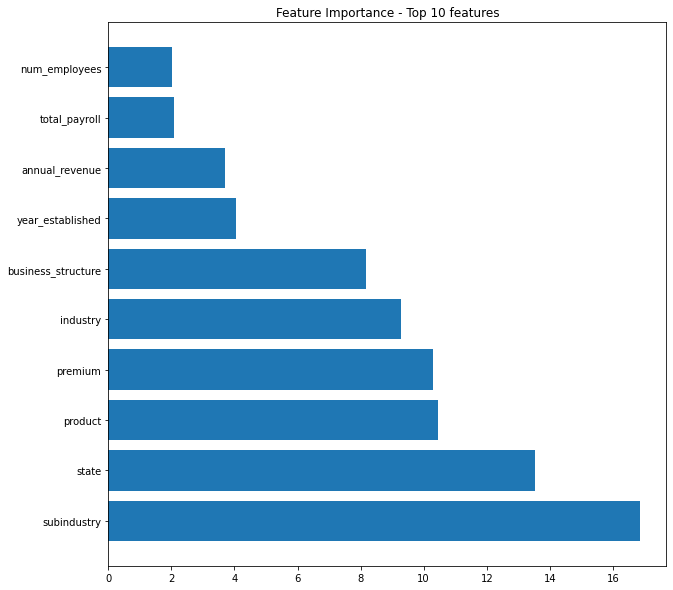

In [57]:
n_features = 10

importances = clf.feature_importances_[0:n_features]
indices = np.argsort(importances)[::-1][0:n_features]
names = [X_train.columns[i] for i in indices][0:n_features]

plt.figure(figsize=(10, 10))
plt.title("Feature Importance - Top {} features".format(n_features))
plt.barh(range(n_features), importances[indices])
plt.yticks(range(n_features), names, rotation=0)
plt.show()

### Confussion matrix

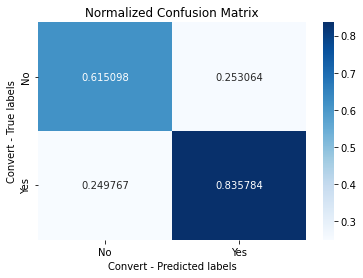

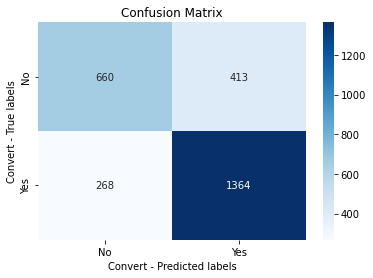

In [58]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_norm = conf_matrix / conf_matrix.astype(float).sum(axis=1)

ax = plt.subplot()
sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Convert - Predicted labels')
ax.set_ylabel('Convert - True labels')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.title('Normalized Confusion Matrix')
plt.show()

ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Convert - Predicted labels')
ax.set_ylabel('Convert - True labels')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.title('Confusion Matrix')
plt.show()

In [59]:
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.71      0.62      0.66      1073
         Yes       0.77      0.84      0.80      1632

    accuracy                           0.75      2705
   macro avg       0.74      0.73      0.73      2705
weighted avg       0.75      0.75      0.74      2705



### ROC curve

In [60]:
y_scores = y_pred_proba_test[:, 1]

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores) 

In [62]:
AUC = auc(fpr, tpr) 
print('AUC: ' + str(AUC))

AUC: 0.8062686164866693


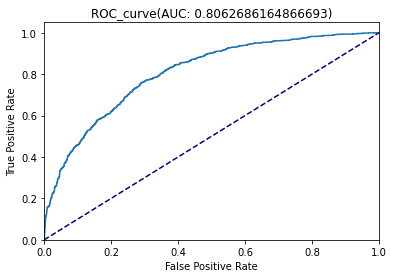

In [63]:
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')')
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate') 
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()  

### Precision-Recall curve

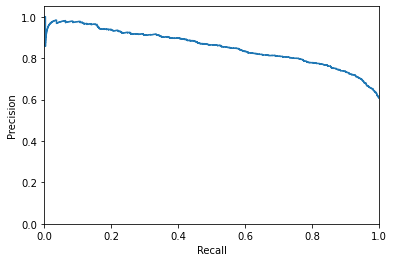

In [64]:
prec, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

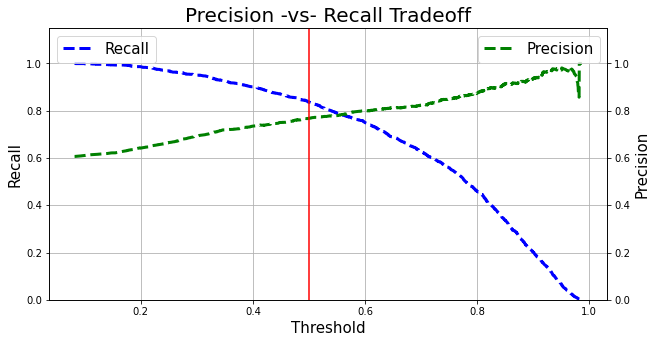

In [65]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(thresholds, recall[:-1], 'b--', linewidth=3, label='Recall')
ax1.set_xlabel('Threshold', fontsize=15)
ax1.set_ylabel('Recall', fontsize=15)
ax1.set_ylim([0, 1.15])
# ax1.axhline(0.1, color='r')
ax1.legend(loc="upper left", fontsize=15)

ax2 = ax1.twinx()  
ax2.plot(thresholds, prec[:-1], 'g--', linewidth=3, label = 'Precision')
ax2.set_xlabel('Threshold', fontsize=20)
ax2.set_ylabel('Precision', fontsize=15)
ax2.set_ylim([0, 1.15])
ax2.legend(loc="upper right", fontsize=15)

ax1.grid()
ax1.set_title("Precision -vs- Recall Tradeoff", fontsize=20)

plt.axvline(x=0.5, c='red')

plt.show()

In [66]:
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.71      0.62      0.66      1073
         Yes       0.77      0.84      0.80      1632

    accuracy                           0.75      2705
   macro avg       0.74      0.73      0.73      2705
weighted avg       0.75      0.75      0.74      2705



In [67]:
threshold = 0.55
y_pred_mod = (clf.predict_proba(X_test)[:,1] >= threshold).astype(bool) 

In [68]:
print(classification_report(y_test, y_pred_mod, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.67      0.66      0.67      1073
         Yes       0.78      0.79      0.78      1632

    accuracy                           0.74      2705
   macro avg       0.73      0.72      0.73      2705
weighted avg       0.74      0.74      0.74      2705



# **`--- CALCULATE PRED ACCOUNT_VALUE ---`**

In [69]:
df_results = X_test_orig.copy()
df_results['convert'] = y_test
df_results['convert_pred'] = y_pred
df_results

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,convert_pred
3399,72d3fe90-16064-8c81-3fe48-0d9973fdb4,FL,Administrative Services and Building Maintenance,Office Administrative Services,2017,75000.0,50000.0,Individual,2,CW_Professional_Liability,500.00,carrier_id_31,1,1
7945,431181c1-2e0ed-d005-1ceee-e1798ce793,NY,"Technology, Media and Telecommunications",Software Publishers,2016,1000000.0,200000.0,Limited Liability Company,2,CW_Special_Events,229.20,carrier_id_40,1,1
10653,9aae6542-8e305-b4ab-962f9-b0d6bac3cb,GA,"Professional, Scientific and Technical Services",Engineering Services,2017,125000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,500.00,carrier_id_60,0,0
7937,44a0d932-ec48-49e0-9f6a-da4db14973b8,WA,Contractors,Residential Remodelers,2018,200000.0,0.0,Individual,0,General_Liability,856.00,carrier_id_9,0,1
4425,3db7a8f5-763b3-4d3e-92b22-37dff1737c,TX,"Professional, Scientific and Technical Services",Engineering Services,2017,65000.0,30000.0,Corporation,2,General_Liability,650.00,carrier_id_60,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,cf9e1d20-de770-2fb9-1b6d6-af3e66b566,NY,Manufacturing,Toilet Preparation Manufacturing,2013,40000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,1926.55,carrier_id_71,1,1
88,e8230f00-98a3-420b-9044-26fed3b55344,NY,Consultants,Administrative Management and General Manageme...,2018,360000.0,0.0,Corporation,0,CW_Professional_Liability,1191.00,carrier_id_31,1,1
4789,42577b86-887f3-adf3-7153d-65e2d682bc,MS,Other Services,Funeral Homes and Funeral Services,1916,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,3120.00,carrier_id_60,0,0
10030,85fe8fd9-07ba-4836-a6a1-8295ae4cb633,NY,Contractors,Flooring Contractors,2018,40000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,1950.75,carrier_id_30,1,1


In [70]:
df_results['account_value_by_product'] = df_results['premium']*df_results['convert']
df_results['account_value_by_product_pred'] = df_results['premium']*df_results['convert_pred']
df_results

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,convert_pred,account_value_by_product,account_value_by_product_pred
3399,72d3fe90-16064-8c81-3fe48-0d9973fdb4,FL,Administrative Services and Building Maintenance,Office Administrative Services,2017,75000.0,50000.0,Individual,2,CW_Professional_Liability,500.00,carrier_id_31,1,1,500.00,500.00
7945,431181c1-2e0ed-d005-1ceee-e1798ce793,NY,"Technology, Media and Telecommunications",Software Publishers,2016,1000000.0,200000.0,Limited Liability Company,2,CW_Special_Events,229.20,carrier_id_40,1,1,229.20,229.20
10653,9aae6542-8e305-b4ab-962f9-b0d6bac3cb,GA,"Professional, Scientific and Technical Services",Engineering Services,2017,125000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,500.00,carrier_id_60,0,0,0.00,0.00
7937,44a0d932-ec48-49e0-9f6a-da4db14973b8,WA,Contractors,Residential Remodelers,2018,200000.0,0.0,Individual,0,General_Liability,856.00,carrier_id_9,0,1,0.00,856.00
4425,3db7a8f5-763b3-4d3e-92b22-37dff1737c,TX,"Professional, Scientific and Technical Services",Engineering Services,2017,65000.0,30000.0,Corporation,2,General_Liability,650.00,carrier_id_60,0,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,cf9e1d20-de770-2fb9-1b6d6-af3e66b566,NY,Manufacturing,Toilet Preparation Manufacturing,2013,40000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,1926.55,carrier_id_71,1,1,1926.55,1926.55
88,e8230f00-98a3-420b-9044-26fed3b55344,NY,Consultants,Administrative Management and General Manageme...,2018,360000.0,0.0,Corporation,0,CW_Professional_Liability,1191.00,carrier_id_31,1,1,1191.00,1191.00
4789,42577b86-887f3-adf3-7153d-65e2d682bc,MS,Other Services,Funeral Homes and Funeral Services,1916,30000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,3120.00,carrier_id_60,0,0,0.00,0.00
10030,85fe8fd9-07ba-4836-a6a1-8295ae4cb633,NY,Contractors,Flooring Contractors,2018,40000.0,0.0,Limited Liability Company,0,Business_Owners_Policy_BOP,1950.75,carrier_id_30,1,1,1950.75,1950.75


In [71]:
actual_account_values = df_results.groupby('account_uuid')['account_value_by_product'].sum().to_frame().rename(columns={'account_value_by_product': 'account_value_actual'}).sort_values(by='account_value_actual', ascending=False)
pred_account_values = df_results.groupby('account_uuid')['account_value_by_product_pred'].sum().to_frame().rename(columns={'account_value_by_product_pred': 'account_value_pred'}).sort_values(by='account_value_pred', ascending=False)

In [72]:
pred_account_values

,account_value_pred
account_uuid,
e31d5efa-e1fdb-e74d-bec81-7c1614bfc9,35579.00
69fdc79b-98ed-424d-8d4d-3837aa686d56,32361.00
b8e47b5f-9cd4d-7f47-72f7e-657d90e809,24729.52
e0a5eea8-bc56-4705-8aa0-1ef260ee3555,22243.00
1218e867-ac2e6-c799-03d8e-a03413279e,20575.62
...,...
5ff2f7ec-1cb4-468c-936e-6ef22e1819fa,0.00
5fe793de-a15ae-088a-3b921-97e9cd51cf,0.00
c60754d8-72dc-4829-a2c1-cf51d033d288,0.00


In [73]:
# -- CALCULATE RESIDUALS --

account_values = actual_account_values.join(pred_account_values).reset_index()
account_values['res'] = account_values['account_value_actual'] - account_values['account_value_pred']
account_values.head(10).style.set_caption("Actual and Predicted Account Values for each user")

,account_uuid,account_value_actual,account_value_pred,res
0,e31d5efa-e1fdb-e74d-bec81-7c1614bfc9,35579.000000,35579.000000,0.000000
1,69fdc79b-98ed-424d-8d4d-3837aa686d56,32361.000000,32361.000000,0.000000
2,b8e47b5f-9cd4d-7f47-72f7e-657d90e809,24729.520000,24729.520000,0.000000
3,e0a5eea8-bc56-4705-8aa0-1ef260ee3555,22243.000000,22243.000000,0.000000
4,d75f61af-8c162-ff3b-48a4c-92866a6c35,20735.000000,0.000000,20735.000000
5,1218e867-ac2e6-c799-03d8e-a03413279e,20575.620000,20575.620000,0.000000
6,e94d4c57-1aa40-6b82-8cdd6-5a5f1b4f6e,19931.000000,0.000000,19931.000000
7,d255dc81-e94ad-f458-fe18e-ccb8ca88be,19403.000000,19403.000000,0.000000
8,9a8247e0-ed1f-4a5b-9e85-2af1ad478093,16964.000000,16964.000000,0.000000
9,55de2f54-9a49-4b0c-a487-d4facf5e01df,15514.000000,15514.000000,0.000000


In [74]:
rmse = mean_squared_error(account_values.account_value_actual, account_values.account_value_pred, squared=False)
rmse

1416.6465349421064

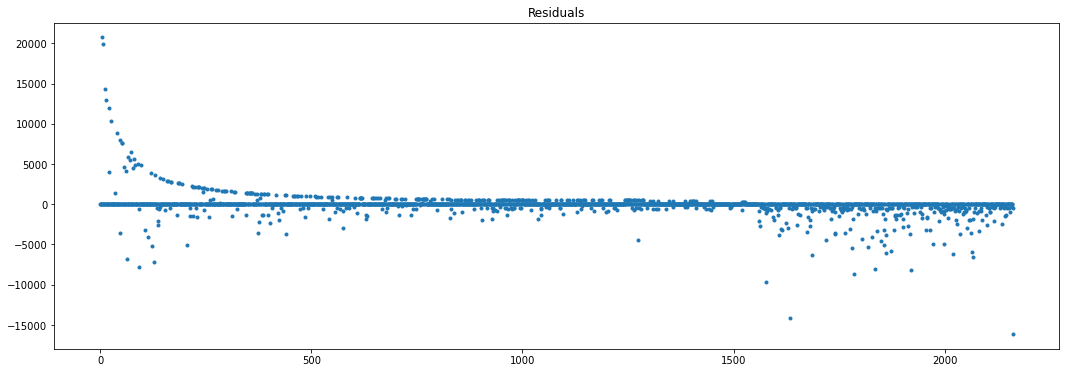

In [75]:
plt.figure(figsize=(18,6))
plt.plot(account_values['res'], '.')
plt.title('Residuals')
plt.show()

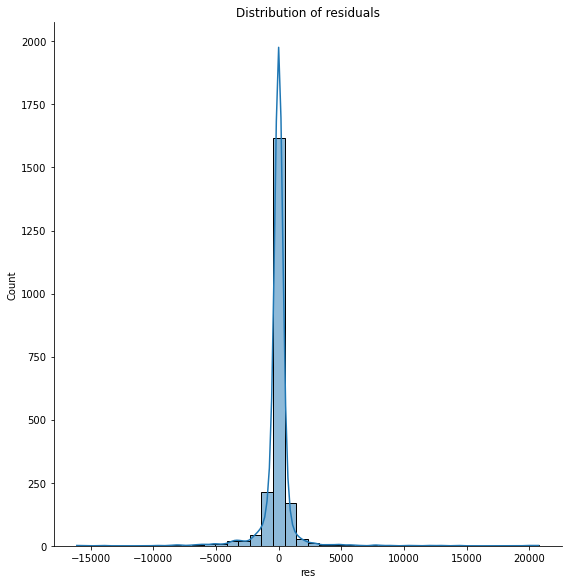

In [76]:
sns.displot(data=account_values, x='res', height=8, kde=True, bins=40)
plt.title('Distribution of residuals')
plt.show()